In [1]:
import pandas as pd

# Läs in data
df = pd.read_csv("nordtech_data.csv")
df_val = pd.read_csv("nordtech_validation.csv")

# Grundläggande EDA
df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2767 entries, 0 to 2766
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_id         2767 non-null   object 
 1   orderrad_id      2767 non-null   object 
 2   orderdatum       2767 non-null   object 
 3   leveransdatum    2767 non-null   object 
 4   produkt_sku      2767 non-null   object 
 5   produktnamn      2767 non-null   object 
 6   kategori         2767 non-null   object 
 7   antal            2767 non-null   object 
 8   pris_per_enhet   2767 non-null   object 
 9   region           2612 non-null   object 
 10  kundtyp          2767 non-null   object 
 11  betalmetod       2651 non-null   object 
 12  kund_id          2767 non-null   object 
 13  leveransstatus   2673 non-null   object 
 14  recension_text   1355 non-null   object 
 15  recensionsdatum  1355 non-null   object 
 16  betyg            1355 non-null   float64
dtypes: float64(1),

(         order_id       orderrad_id  orderdatum    leveransdatum produkt_sku  \
 0  ORD-2024-00001  ORD-2024-00001-1  2024-05-19       2024-05-22   SKU-WC001   
 1  ORD-2024-00002  ORD-2024-00002-1  2024-12-02  5 december 2024   SKU-HB001   
 2  ORD-2024-00003  ORD-2024-00003-1  2024-12-31       2025-01-03   SKU-SD001   
 3  ORD-2024-00003  ORD-2024-00003-2  2024-12-31       2025-01-03   SKU-SD002   
 4  ORD-2024-00003  ORD-2024-00003-3  2024-12-31       2025-01-03   SKU-MS001   
 
         produktnamn   kategori antal pris_per_enhet     region  kundtyp  \
 0     Webbkamera HD  Tillbehör     1        SEK 799    Uppsala   Privat   
 1  USB-C Hub 7-port  Tillbehör     1         549.00   Göteborg   Privat   
 2    Extern SSD 1TB    Lagring     1        1199.00        NaN  Företag   
 3  Extern SSD 500GB    Lagring    10         699 kr  Stockholm  Företag   
 4    Trådlös Mus X1  Tillbehör     1         399.00  Stockholm  Företag   
 
   betalmetod    kund_id leveransstatus  \
 0       Ko

In [2]:
import pandas as pd
import numpy as np

# Läs in rådata
df = pd.read_csv("nordtech_data.csv")
df_val = pd.read_csv("nordtech_validation.csv")

df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2767 entries, 0 to 2766
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_id         2767 non-null   object 
 1   orderrad_id      2767 non-null   object 
 2   orderdatum       2767 non-null   object 
 3   leveransdatum    2767 non-null   object 
 4   produkt_sku      2767 non-null   object 
 5   produktnamn      2767 non-null   object 
 6   kategori         2767 non-null   object 
 7   antal            2767 non-null   object 
 8   pris_per_enhet   2767 non-null   object 
 9   region           2612 non-null   object 
 10  kundtyp          2767 non-null   object 
 11  betalmetod       2651 non-null   object 
 12  kund_id          2767 non-null   object 
 13  leveransstatus   2673 non-null   object 
 14  recension_text   1355 non-null   object 
 15  recensionsdatum  1355 non-null   object 
 16  betyg            1355 non-null   float64
dtypes: float64(1),

(         order_id       orderrad_id  orderdatum    leveransdatum produkt_sku  \
 0  ORD-2024-00001  ORD-2024-00001-1  2024-05-19       2024-05-22   SKU-WC001   
 1  ORD-2024-00002  ORD-2024-00002-1  2024-12-02  5 december 2024   SKU-HB001   
 2  ORD-2024-00003  ORD-2024-00003-1  2024-12-31       2025-01-03   SKU-SD001   
 3  ORD-2024-00003  ORD-2024-00003-2  2024-12-31       2025-01-03   SKU-SD002   
 4  ORD-2024-00003  ORD-2024-00003-3  2024-12-31       2025-01-03   SKU-MS001   
 
         produktnamn   kategori antal pris_per_enhet     region  kundtyp  \
 0     Webbkamera HD  Tillbehör     1        SEK 799    Uppsala   Privat   
 1  USB-C Hub 7-port  Tillbehör     1         549.00   Göteborg   Privat   
 2    Extern SSD 1TB    Lagring     1        1199.00        NaN  Företag   
 3  Extern SSD 500GB    Lagring    10         699 kr  Stockholm  Företag   
 4    Trådlös Mus X1  Tillbehör     1         399.00  Stockholm  Företag   
 
   betalmetod    kund_id leveransstatus  \
 0       Ko

In [3]:
def parse_swedish_dates(series):
    swedish_months = {
        "januari": "January",
        "februari": "February",
        "mars": "March",
        "april": "April",
        "maj": "May",
        "juni": "June",
        "juli": "July",
        "augusti": "August",
        "september": "September",
        "oktober": "October",
        "november": "November",
        "december": "December"
    }

    s = series.astype(str).str.lower()
    for swe, eng in swedish_months.items():
        s = s.str.replace(swe, eng, regex=False)

    return pd.to_datetime(s, errors="coerce")


df["orderdatum_dt"] = parse_swedish_dates(df["orderdatum"])
df["leveransdatum_dt"] = parse_swedish_dates(df["leveransdatum"])


In [4]:
def clean_price(series):
    cleaned = (
        series.astype(str)
        .str.lower()
        .str.replace("sek", "", regex=False)
        .str.replace("kr", "", regex=False)
        .str.replace(" ", "", regex=False)
        .str.replace(",", ".", regex=False)
        .str.replace(r"[^0-9.]", "", regex=True)
    )
    return pd.to_numeric(cleaned, errors="coerce")


df["pris_enhet_sek"] = clean_price(df["pris_per_enhet"])


In [5]:
df[["pris_per_enhet", "pris_enhet_sek"]].head(10)


,pris_per_enhet,pris_enhet_sek
0,SEK 799,799.0
1,549.00,549.0
2,1199.00,1199.0
3,699 kr,699.0
4,399.00,399.0
5,799.00,799.0
6,549.00,549.0
7,1899.00,1899.0
8,599.00,599.0
9,399.00,399.0


In [6]:
# Ta bort rader utan giltigt pris
df = df[df["pris_enhet_sek"].notna()]


In [7]:
# Antal
df["antal"] = pd.to_numeric(df["antal"], errors="coerce")

# Betalmetod
df["betalmetod"] = (
    df["betalmetod"]
    .str.strip()
    .str.lower()
    .replace({
        "faktura": "Faktura",
        "kort": "Kort",
        "swish": "Swish"
    })
)

# Region
df["region"] = (
    df["region"]
    .str.lower()
    .replace({
        "stckhlm": "stockholm",
        "stocholm": "stockholm"
    })
    .str.title()
)


In [8]:
df["region"] = df["region"].fillna("Okänd")
df["betalmetod"] = df["betalmetod"].fillna("Okänd")
df["leveransstatus"] = df["leveransstatus"].fillna("Okänd")

# Filtrera bort orimliga datum
df = df[df["leveransdatum_dt"] >= df["orderdatum_dt"]]


In [9]:
df["rad_total"] = df["antal"] * df["pris_enhet_sek"]

df["leveranstid_dagar"] = (
    df["leveransdatum_dt"] - df["orderdatum_dt"]
).dt.days

df["vecka"] = df["orderdatum_dt"].dt.isocalendar().week
df["månad"] = df["orderdatum_dt"].dt.month

df.head()


,order_id,orderrad_id,orderdatum,leveransdatum,produkt_sku,produktnamn,kategori,antal,pris_per_enhet,region,...,recension_text,recensionsdatum,betyg,orderdatum_dt,leveransdatum_dt,pris_enhet_sek,rad_total,leveranstid_dagar,vecka,månad
0,ORD-2024-00001,ORD-2024-00001-1,2024-05-19,2024-05-22,SKU-WC001,Webbkamera HD,Tillbehör,1.0,SEK 799,Uppsala,...,NaN,NaN,NaN,2024-05-19,2024-05-22,799.0,799.0,3,20,5
2,ORD-2024-00003,ORD-2024-00003-1,2024-12-31,2025-01-03,SKU-SD001,Extern SSD 1TB,Lagring,1.0,1199.00,Okänd,...,Stämmer inte överens med produktbeskrivningen.,2025-01-12,2.0,2024-12-31,2025-01-03,1199.0,1199.0,3,1,12
3,ORD-2024-00003,ORD-2024-00003-2,2024-12-31,2025-01-03,SKU-SD002,Extern SSD 500GB,Lagring,10.0,699 kr,Stockholm,...,"Leveransen tog lite längre än utlovat, men pro...",2025-01-14,3.0,2024-12-31,2025-01-03,699.0,6990.0,3,1,12
4,ORD-2024-00003,ORD-2024-00003-3,2024-12-31,2025-01-03,SKU-MS001,Trådlös Mus X1,Tillbehör,1.0,399.00,Stockholm,...,NaN,NaN,NaN,2024-12-31,2025-01-03,399.0,399.0,3,1,12
5,ORD-2024-00004,ORD-2024-00004-1,2024-04-22,2024-04-26,SKU-WC001,Webbkamera HD,Tillbehör,NaN,799.00,Örebro,...,NaN,NaN,NaN,2024-04-22,2024-04-26,799.0,NaN,4,17,4


### Sentimentanalys

Kundrecensioner analyserades med en förtränad BERT-modell.
Resultatet klassificerades som positivt, neutralt eller negativt.


In [10]:
from transformers import pipeline

sentiment_model = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    framework="pt"
)


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

In [11]:
def classify_sentiment(text):
    if pd.isna(text):
        return "Ingen recension"
    
    try:
        result = sentiment_model(text[:512], truncation=True)[0]
        stars = int(result["label"][0])

        if stars <= 2:
            return "Negativ"
        elif stars == 3:
            return "Neutral"
        else:
            return "Positiv"
    except Exception:
        return "Okänt"


In [12]:
mask = df["recension_text"].notna()
df.loc[mask, "sentiment"] = df.loc[mask, "recension_text"].apply(classify_sentiment)
df["sentiment"] = df["sentiment"].fillna("Ingen recension")


In [13]:
df["sentiment"].value_counts()


sentiment
Ingen recension    1189
Positiv             745
Neutral             219
Negativ             193
Name: count, dtype: int64

**Resultat av sentimentanalys**

Majoriteten av orderraderna saknar kundrecension, vilket är vanligt inom e-handel.
Bland inkomna recensioner dominerar positiva omdömen, följt av neutrala och negativa.
Detta indikerar överlag god kundnöjdhet, samtidigt som negativa recensioner pekar på områden med förbättringspotential.


In [14]:
df[["recension_text", "betyg", "sentiment"]].dropna().head(10)


,recension_text,betyg,sentiment
2,Stämmer inte överens med produktbeskrivningen.,2.0,Negativ
3,"Leveransen tog lite längre än utlovat, men pro...",3.0,Neutral
7,Medelmåttig upplevelse.,3.0,Positiv
10,Prisvärt och bra kvalitet. Kommer köpa igen.,4.0,Positiv
12,Dålig kundservice när jag försökte reklamera.,1.0,Negativ
13,För dyrt för vad man får.,2.0,Neutral
21,Riktigt nöjd! Använder den dagligen.,4.0,Positiv
24,Mycket nöjd med köpet. Snabb leverans också!,4.0,Positiv
27,Snabb leverans och produkten är fantastisk!,4.0,Positiv
28,Produkten var trasig vid leverans. Besviken.,1.0,Neutral


In [15]:
import sqlite3

### Load till SQLite

Den rensade och transformerade datan sparades i en lokal SQLite-databas.
Efter laddning verifierades datans innehåll genom återläsning och radantal.


In [16]:
# Skapa (eller anslut till) SQLite-databas
conn = sqlite3.connect("nordtech.db")

# Spara dataframe till databas
df.to_sql(
    name="orders_clean",
    con=conn,
    if_exists="replace",
    index=False
)

conn.close()

In [17]:
conn = sqlite3.connect("nordtech.db")

row_count = pd.read_sql(
    "SELECT COUNT(*) AS rows FROM orders_clean",
    conn
)

conn.close()

row_count


,rows
0,2346


In [18]:
df.shape

(2346, 25)

## KPI 1 – Försäljning per vecka

Denna KPI visar hur den totala försäljningen utvecklas över tid,
vilket kan användas för att identifiera säsongsmönster och perioder
med hög eller låg efterfrågan.


In [19]:
weekly_sales = (
    df.groupby("vecka")["rad_total"]
    .sum()
    .reset_index()
    .sort_values("vecka")
)

weekly_sales.head()


,vecka,rad_total
0,1,321899.0
1,2,279086.0
2,3,617641.0
3,4,96548.0
4,5,204807.0


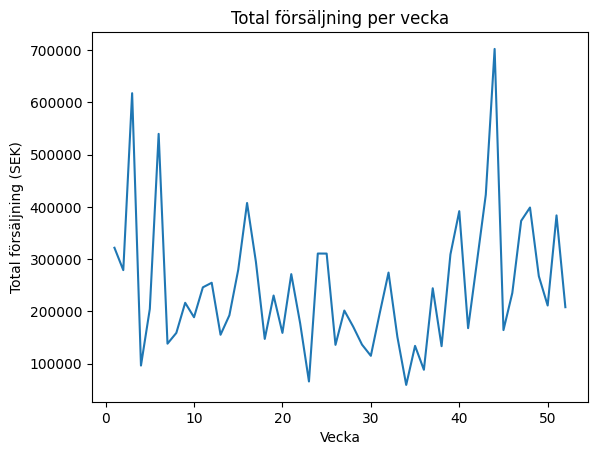

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(weekly_sales["vecka"], weekly_sales["rad_total"])
plt.xlabel("Vecka")
plt.ylabel("Total försäljning (SEK)")
plt.title("Total försäljning per vecka")
plt.show()


**Tolkning:**  
Försäljningen varierar mellan veckor med tydliga toppar, vilket kan
indikera kampanjer eller säsongsvariationer.


## KPI 2 – Genomsnittligt ordervärde (AOV)

Det genomsnittliga ordervärdet visar hur mycket en kund i snitt
spenderar per order. KPI:n är central för att förstå kundbeteende
och lönsamhet, särskilt inom e-handel.


In [21]:
order_values = (
    df.groupby("order_id")["rad_total"]
    .sum()
)

order_values.head()


order_id
ORD-2024-00001      799.0
ORD-2024-00003     8588.0
ORD-2024-00004        0.0
ORD-2024-00005    13582.0
ORD-2024-00006     9998.0
Name: rad_total, dtype: float64

In [22]:
# Exkludera ordrar med 0 kr
order_values_nonzero = order_values[order_values > 0]

# Beräkna genomsnittligt ordervärde
average_order_value = order_values_nonzero.mean()
average_order_value


np.float64(8870.378453038675)

**Tolkning:**  
Det genomsnittliga ordervärdet beräknades efter att ordrar med nollvärde
exkluderats. Dessa bedöms inte representera faktiska försäljningstillfällen
och skulle annars snedvrida KPI:n. Resultatet ger därför en mer rättvisande
bild av kundernas genomsnittliga köpbeteende.



## KPI 3 – Leveranstid

Leveranstid mäter antalet dagar mellan orderdatum och leveransdatum.
KPI:n är central för kundupplevelsen, då längre leveranstider ofta
påverkar kundnöjdheten negativt.


In [23]:
df["leveranstid_dagar"].describe()


count    2346.000000
mean        2.948423
std         1.028954
min         2.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         7.000000
Name: leveranstid_dagar, dtype: float64

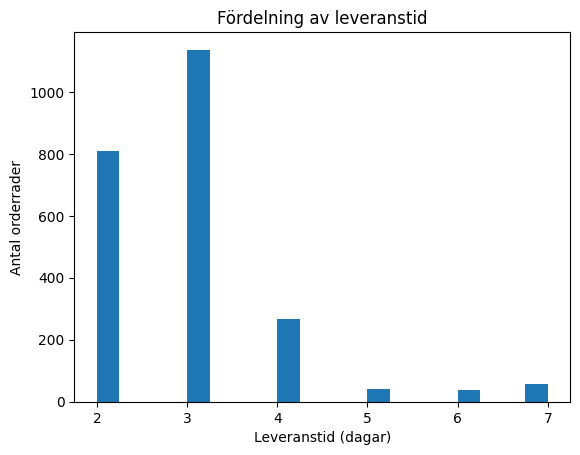

In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["leveranstid_dagar"].dropna(), bins=20)
plt.xlabel("Leveranstid (dagar)")
plt.ylabel("Antal orderrader")
plt.title("Fördelning av leveranstid")
plt.show()


**Tolkning:**  
De flesta leveranser sker inom ett begränsat antal dagar, vilket indikerar
en relativt effektiv logistik. Samtidigt förekommer längre leveranstider,
vilket kan påverka kundupplevelsen negativt och bör analyseras vidare.


## KPI 4 – Kundnöjdhet per produktkategori

Denna KPI analyserar kundnöjdhet baserat på sentiment från
kundrecensioner, uppdelat per produktkategori. Syftet är att identifiera
kategorier med hög respektive låg kundnöjdhet.


In [25]:
sentiment_by_category = (
    df[df["sentiment"] != "Ingen recension"]
    .groupby(["kategori", "sentiment"])
    .size()
    .unstack(fill_value=0)
)

sentiment_by_category


sentiment,Negativ,Neutral,Positiv
kategori,,,
Bildskärmar,36,28,103
Datorer,35,37,123
Lagring,26,57,89
Ljud,26,27,71
Tillbehör,70,70,359


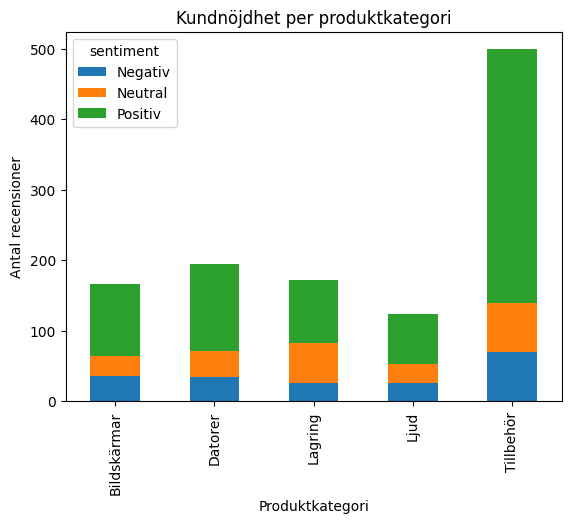

In [26]:
sentiment_by_category.plot(kind="bar", stacked=True)
plt.xlabel("Produktkategori")
plt.ylabel("Antal recensioner")
plt.title("Kundnöjdhet per produktkategori")
plt.show()


**Tolkning:**  
Analysen visar att kundnöjdheten varierar mellan produktkategorier.
Vissa kategorier domineras av positiva recensioner, medan andra har en
högre andel neutrala eller negativa omdömen. Detta kan indikera skillnader
i produktkvalitet, leveransförväntningar eller kundservice kopplat till
specifika kategorier.
